# Hierachical Clustering

## 2. Efficient Implementation

### Nearest-Neighbour Chain

In [1]:
import time
import collections
import numpy as np
import pandas as pd

from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.preprocessing import StandardScaler, normalize
from sklearn.cluster import AgglomerativeClustering 
from sklearn.decomposition import PCA

import matplotlib.pyplot as plt

## 2-1 Nearest-Neighbour Chain Implementation

In [2]:
# carry over from task 1

# the distance function defined as the euclidian distance between two points
def euclidean_distance(point1, point2):
    return np.linalg.norm(np.array(point1) - np.array(point2)) # euclidean distance is the l2 norm, with the default value of the 'ord' as 2

# initialize the distance matrix between all points
def initialize_distance_matrix(points):
    num_points = len(points)    # total number of points in the dataset
    # distance_matrix will store the Euclidean distances between every pair of points
    distance_matrix = np.zeros((num_points, num_points))    # initialized as a square matrix of zero values with dimensions num_points x num_points,
    # which will later be overwritten for non-diagonal elements
    for i in range(num_points):
        for j in range(i + 1, num_points):
            distance = euclidean_distance(points[i], points[j])
            distance_matrix[i][j] = distance
            distance_matrix[j][i] = distance
    return distance_matrix

In [3]:
# merge two clusters
def merge_clusters(cluster1, cluster2):
    return [*cluster1, *cluster2]


# use each point in a cluster as tuple to construct a key to be added in cluster_labels
def create_cluster_key(cluster):
    return tuple([tuple(c) for c in cluster]) if len(cluster) > 1 else tuple(*cluster)


# adds an entry to cluster_labels if it does not exist already and returns said key
def add_cluster_label(cluster_labels, new_cluster):
    new_cluster_key = create_cluster_key(new_cluster)
            
    if new_cluster_key not in cluster_labels:
        cluster_labels[new_cluster_key] = len(cluster_labels) # the key value increments +1 for every key added
        
    return new_cluster_key                                    # return the newly created key 


# apply consistent tie breaking through returning the tie breaking index as the lowest index apearing in the labeled cluster set
def get_tie_breaking_index(closest_points, cluster_labels):
    tie_breaking_index = 0                          
    min_label = np.inf
    
    for i, point in enumerate(closest_points):          # for each point
        cluster_label = cluster_labels[tuple(point[0])] # get order of the cluster by query cluster labels
        if cluster_label < min_label:                   # if the cluster label is lower than the min label
            min_label = cluster_label                   # assign this cluster label as min label
            tie_breaking_index = i                      # update index
            
    return tie_breaking_index


# evaluate which point of which cluster in the set of all clusters is closest to the current cluster
def find_closest_cluster(cluster, all_clusters, lookup_table, cluster_labels):        
    min_distance = np.inf
    closest_clusters = []
    closest_points = []    
    
    for i, other_cluster in enumerate(all_clusters): # for each cluster in the set of all clusters
        if other_cluster != cluster:                 # if clusters are not equal
            
            for point1 in cluster:                   # iterate through each point in each cluster
                for point2 in other_cluster:                    
                                                                                                        
                    oc_label, cc_label = cluster_labels[tuple(point2)], cluster_labels[tuple(point1)]  # get label indexes for lookup
                    distance = lookup_table[oc_label][cc_label]                                        # get distance from lookup table

                    if distance <= min_distance:     # if the distance is smaller or equal to the last min distance                        
                        if distance != min_distance: # if they are not equal there is no tie 
                            closest_clusters = []    # reste the closes_clusters list
                            closest_points = []      # reste the closes_points list
                        
                        min_distance = distance                       # assign new min distance                                               
                        closest_points.append([point2, min_distance]) # add closest point to list of closest points
                        closest_clusters.append(other_cluster)        # add closest_cluster to list of closest_clusters

    if len(closest_clusters) == 1:                        # if there is no tie breaking nessecary since there is just one cluster candidate
        return closest_clusters[0], closest_points[0][1]  # return its element and its min distance as well
       
    tie_breaking_index = get_tie_breaking_index(closest_points, cluster_labels)        # determine the tie breaking index
    return closest_clusters[tie_breaking_index], closest_points[tie_breaking_index][1] # return the corresponding cluster to the tie breaking index


# run the nearest neighbour chain algorithm
def nearest_neighbour_chain(data):        
    stack = []                                      # initialize an empty stack that holds the current cluster to process on top
    linkage_matrix = []                             # initialize the empty linkage matrix
    lookup_table = initialize_distance_matrix(data) # construct a lookup table holding each point with its distance to all the other points upfront to reduce computing the minimum distance at every iteration

    clusters = collections.deque([[[*point]] for point in data])           # transform data points to clusters and store them in a deque
    cluster_labels = {tuple(cluster): i for i, cluster in enumerate(data)} # label each point with an index - use it to build a linkage matrix and access the distances in the lookup table 
   
    while len(clusters) > 1:          # while there is more than one cluster in the set of all clusters
        
        if len(stack) == 0:           # if stack is empty
            stack.append(clusters[0]) # add an arbitrary cluster to the stack 

        current_cluster = stack.pop() # move the top value off the stack 

        closest_cluster, min_distance = find_closest_cluster(current_cluster, clusters, lookup_table, cluster_labels) # compute the closest cluster to the current cluster

        if stack and closest_cluster == stack[-1]: # if the closest cluster is equal to the current top of the stack
            stack.pop()                            # remove the previous closest cluster from the stack
            clusters.remove(closest_cluster)       # remove the closest cluster from the set of all clusters
            clusters.remove(current_cluster)       # remove the current cluster from the set of all clusters

            merged_cluster = merge_clusters(current_cluster, closest_cluster) # form the merged cluster from both clusters            
            clusters.append(merged_cluster)                                   # append the merged cluster to the set of all clusters            
            
            add_cluster_label(cluster_labels, merged_cluster)                 # add a new key to the cluster labels that represents the merged cluster
            
            current_cluster_key = create_cluster_key(current_cluster)         # get the cluster key of the current cluster
            closest_cluster_key = create_cluster_key(closest_cluster)         # get the cluster key of the closest cluster                    

            # append to the linkage matrix the index of the closest cluster and the current cluster from the cluster labels, their distance and the length of the merged cluster
            linkage_matrix.append([cluster_labels[closest_cluster_key], cluster_labels[current_cluster_key], min_distance, len(merged_cluster)])
        else:                             # otherwise
            stack.append(current_cluster) # add current cluster to the stack
            stack.append(closest_cluster) # add closest cluster to the stack

    return linkage_matrix


#### Applying the Nearest-Neighbour Chain algorithm to randomly generated data:

In [25]:
np.random.seed(42) 
# generate random points
random_points = np.random.rand(10, 2) * 100

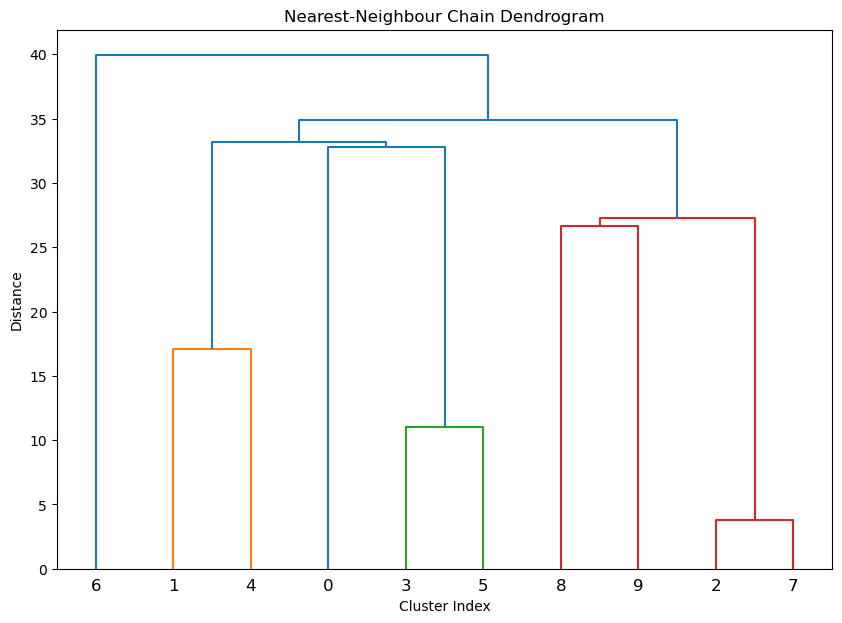

In [30]:
# start = time.perf_counter()
linkage_matrix = nearest_neighbour_chain(random_points)
# end = time.perf_counter()

#print('elapsed time', end - start)

plt.figure(figsize=(10, 7))
dendrogram(linkage_matrix)
plt.title('Nearest-Neighbour Chain Dendrogram')
plt.xlabel('Cluster Index')
plt.ylabel('Distance')
plt.show()

## 2-2 Applying to Dataset

In [35]:
raw_df = pd.read_csv('CC_GENERAL.csv') # load dataset
raw_df = raw_df.drop('CUST_ID', axis = 1) # removing the 'Customer ID' label column
raw_df.ffill(inplace=True) # replace the missing values with the last valid (non-null) value

# standardize data
scaler = StandardScaler() 
scaled_df = scaler.fit_transform(raw_df) 
  
# normalizing the data 
normalized_df = normalize(scaled_df) 
  
# converting the numpy array into a pandas DataFrame 
normalized_df = pd.DataFrame(normalized_df) 

# since we are using a large dataset, 
# we will reduce the dimensions of the data 
pca = PCA(n_components = 2) # reduce to 2 dimensions
X_principal = pca.fit_transform(normalized_df) 
X_principal = pd.DataFrame(X_principal) 
X_principal.columns = ['P1', 'P2'] 

data_sample = X_principal.sample(n=100, random_state=1).values

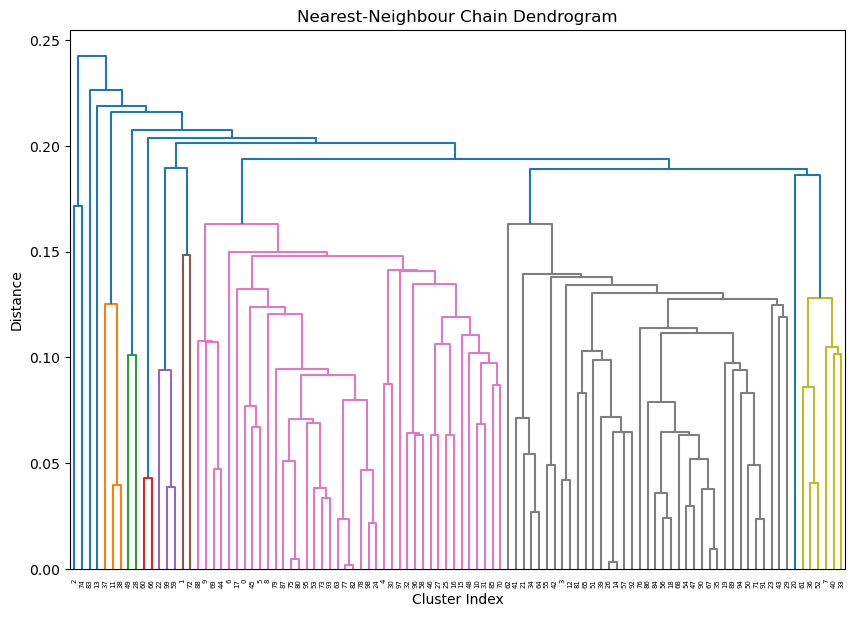

In [37]:
# applying the sample data to the Nearest-Neighbour Chain algorithm
linkage_matrix = nearest_neighbour_chain(data_sample)

# plot the dendrogram
plt.figure(figsize=(10, 7)) 

# use distance sort - NNC builds its linkage matrix in a different order compared to Agglomerative Clustering. We need to sort the linkage matrix by its distances to compare the dendograms better.
dendrogram(linkage_matrix, distance_sort=True)

plt.title('Nearest-Neighbour Chain Dendrogram')
plt.xlabel('Cluster Index')
plt.ylabel('Distance')
plt.show()

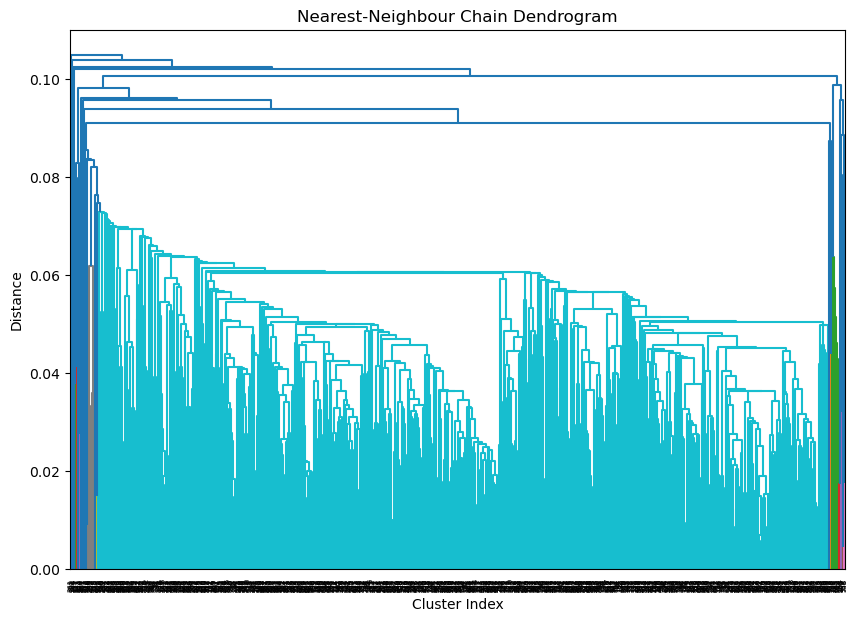

In [41]:
# increase the number of data samples
data_sample = X_principal.sample(n=1000, random_state=1).values

# applying the sample data to the Nearest-Neighbour Chain algorithm
linkage_matrix = nearest_neighbour_chain(data_sample)

# plot the dendrogram
plt.figure(figsize=(10, 7)) 

# use distance sort - NNC builds its linkage matrix in a different order compared to Agglomerative Clustering. We need to sort the linkage matrix by its distances to compare the dendograms better.
dendrogram(linkage_matrix, distance_sort=True)

plt.title('Nearest-Neighbour Chain Dendrogram')
plt.xlabel('Cluster Index')
plt.ylabel('Distance')
plt.show()

## 2-3 Built-in Implementation
### Using sklearn.cluster.AgglomerativeClustering for Hierarchical Clustering

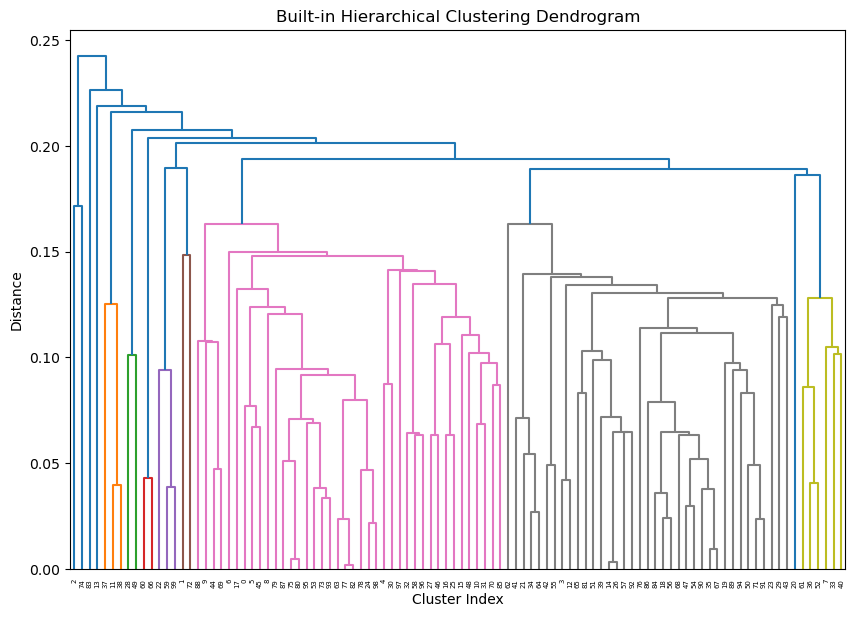

In [8]:
# applying the sample data to the built-in hierarchical clustering function
# using single-linkage
linked = linkage(data_sample, method='single')

# plot the dendrogram
plt.figure(figsize=(10, 7))
dendrogram(linked)
plt.title('Built-in Hierarchical Clustering Dendrogram')
plt.xlabel('Cluster Index')
plt.ylabel('Distance')
plt.show()

## 2-4 Compare execution time 
### Agglomerative Clustering - Naive Hierachical Clustering - Nearest-Neigbour Chain 

#### Naive HC from task 1

In [9]:
def naive_hc(points):
    num_points = len(points)    # total number of data points
    clusters = [{i} for i in range(num_points)]     # a list of sets, each set containing indices representing individual points, initially each point is its own cluster
    distance_matrix = initialize_distance_matrix(points)    # containing distances between all pairs of points.
    linkage_matrix = []     # store the result of the clustering process

    cluster_labels = list(range(num_points))    # labels for each cluster starting from 0 to num_points-1
    current_cluster_label = num_points  # a label assigned to new clusters formed by merging existing ones

    while len(clusters) > 1:    # until only one cluster remains
        min_distance = np.inf   # initialized to infinity
        clusters_to_merge = (-1, -1)    # used to store the indices of the clusters to merge

        # iterate over all pairs of clusters
        for i in range(len(clusters)):
            # for each pair of clusters
            for j in range(i + 1, len(clusters)):
                # calculate the minimum distance between any point in clusters[i] and any point in clusters[j]
                dist = min(distance_matrix[a][b] for a in clusters[i] for b in clusters[j])
                if dist < min_distance:     # if the distance (dist) is less than min_distance
                    min_distance = dist     # update the min_distance
                    clusters_to_merge = (i, j)      # update with the current indices (i, j)

        i, j = clusters_to_merge
        new_cluster = clusters[i] | clusters[j]     # form a new cluster by taking the union of clusters i and j
        clusters.append(new_cluster)    # add the new cluster to the list of clusters

        # track cluster indices for linkage matrix
        new_row = [cluster_labels[i], cluster_labels[j], min_distance, len(new_cluster)]
        linkage_matrix.append(new_row)

        # update cluster labels
        cluster_labels.append(current_cluster_label)
        current_cluster_label += 1

        # remove the merged clusters
        clusters.pop(max(i, j))
        clusters.pop(min(i, j))
        cluster_labels.pop(max(i, j))
        cluster_labels.pop(min(i, j))

    return np.array(linkage_matrix)

In [10]:
import time

def measure_runtime(clustering_func, data):
    start_time = time.time()
    clustering_func(data)
    end_time = time.time()
    return end_time - start_time


In [42]:
sample_sizes = [100, 500, 1000, 1500, 2000]
naive_times = []
sklearn_times = []
nnc_times = []

for size in sample_sizes:
    subset = X_principal.iloc[:size].to_numpy()
    
    # naive hierarchical clustering
    naive_time = measure_runtime(lambda data: naive_hc(data), subset)
    naive_times.append(naive_time)
    
    # AgglomerativeClustering from scikit-Learn
    sklearn_time = measure_runtime(lambda data: AgglomerativeClustering().fit(data), subset)
    sklearn_times.append(sklearn_time)
    
    # Nearest Neighbour Chain
    nnc_time = measure_runtime(lambda data: nearest_neighbour_chain(data), subset)
    nnc_times.append(nnc_time)

print("Naive times:", naive_times)
print("Sklearn times:", sklearn_times)
print('nnc times:', nnc_times)

Naive times: [0.15324664115905762, 17.795825958251953, 179.41437363624573, 735.1778769493103, 1736.075403213501]
Sklearn times: [0.01794886589050293, 0.007460355758666992, 0.02280592918395996, 0.04271745681762695, 0.07334470748901367]
nnc times: [0.06325602531433105, 5.287405729293823, 38.195730447769165, 103.78978991508484, 234.13101768493652]


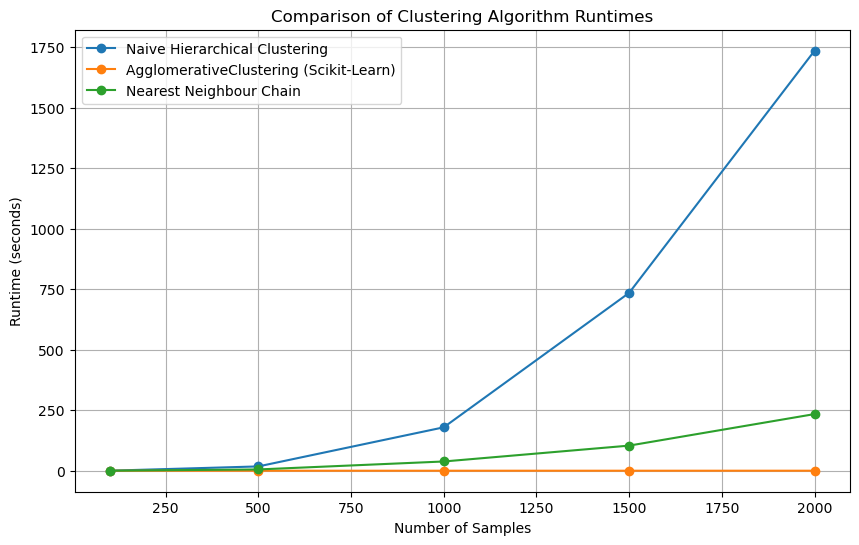

In [48]:
plt.figure(figsize=(10, 6))
plt.plot(sample_sizes, naive_times, label='Naive Hierarchical Clustering', marker='o')
plt.plot(sample_sizes, sklearn_times, label='AgglomerativeClustering (Scikit-Learn)', marker='o')
plt.plot(sample_sizes, nnc_times, label='Nearest Neighbour Chain', marker='o')
plt.xlabel('Number of Samples')
plt.ylabel('Runtime (seconds)')
plt.title('Comparison of Clustering Algorithm Runtimes')
plt.legend()
plt.grid(True)
plt.show()

### Resources

- https://www.kaggle.com/code/vipulgandhi/hierarchical-clustering-explanation/notebook
- https://scikit-learn.org/stable/modules/generated/sklearn.cluster.AgglomerativeClustering.html
- https://docs.scipy.org/doc/scipy/reference/generated/scipy.cluster.hierarchy.dendrogram.html